Car Price Regression Problem
This project involves predicting car prices in the American market based on a dataset containing various features related to cars. The goal is to understand the factors affecting car prices and use regression models to predict them.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import joblib

In [2]:
# Load dataset
data=pd.read_csv('CarPrice.csv')

In [3]:
data.head(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
# get the size of data
data.shape

(205, 26)

In [5]:
# copying data 
df=data.copy()

In [6]:
#Getting information about data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Data Preprocessing: Dropping Irrelevant Columns and Handling Duplicates
In this step, we clean the dataset by removing unnecessary columns and duplicates. The car_ID column, which serves as an identifier and doesn't provide any useful information for predicting car prices, is dropped. Similarly, the CarName column, which contains the car names and is not relevant for the regression task, is also removed. Finally, any duplicate rows in the dataset are eliminated to ensure that each car is represented only once, maintaining the quality of the data for model training.

In [7]:
#Droping car_ID which is an irrelevant column
df.drop('car_ID', axis=1, inplace=True)

In [8]:
df['CarName'].head()


0          alfa-romero giulia
1         alfa-romero stelvio
2    alfa-romero Quadrifoglio
3                 audi 100 ls
4                  audi 100ls
Name: CarName, dtype: object

In [9]:
# Droping Car name
df.drop('CarName', axis=1, inplace=True)

In [10]:
#Checking for duplicated rows
df.duplicated().sum()

1

In [11]:
#Handle duplicates
df.drop_duplicates(inplace=True)

Exploratory Data Analysis (EDA)

In this step, we analyze the distribution of the target variable (price) and numerical features in the dataset.

Target Variable Distribution:
The distribution of the price variable is first visualized using a histogram with a KDE curve. Since the price variable exhibits a skewed distribution, a log transformation is applied to normalize it. The distribution of the transformed log_price is then plotted to observe its improved shape.

Outlier Detection and Capping:
Outliers in numerical features are detected using the Interquartile Range (IQR) method. For each numeric column, values outside the range defined by 1.5 times the IQR are considered outliers. These outliers are capped at the mean value of the respective column to minimize their impact on model performance.

Boxplots and Distribution Plots:
Boxplots are generated for each numeric feature to visualize the spread of the data and the effect of outlier capping. Additionally, distribution plots for all numeric columns are displayed to check their individual distributions after outlier handling.

Correlation Analysis:
A correlation heatmap is created to identify relationships between numerical features. This helps in understanding how features are correlated with each other, which can guide feature selection for modeling.

In [12]:
numeric_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                'enginesize', 'boreratio', 'stroke', 'compressionratio', 
                'horsepower', 'peakrpm', 'citympg', 'highwaympg']

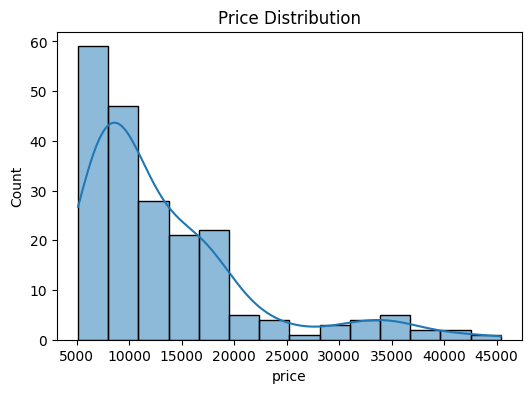

In [13]:
# Plot distribution of target variable (Price)
plt.figure(figsize=(6,4))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

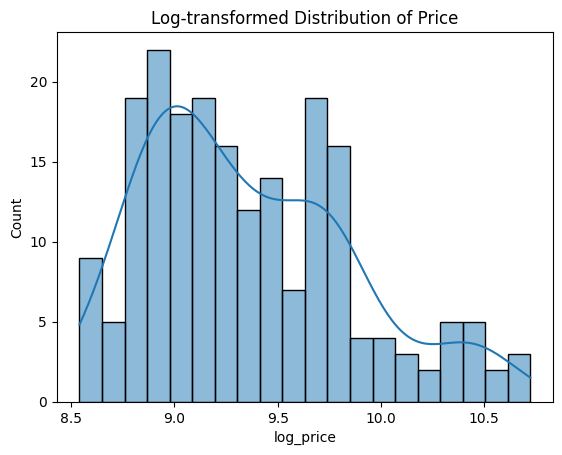

In [14]:
# Apply log transformation to the price column
df['log_price'] = np.log(df['price'])

# Check distribution of the transformed variable
sns.histplot(df['log_price'], kde=True, bins=20)
plt.title('Log-transformed Distribution of Price')
plt.show()

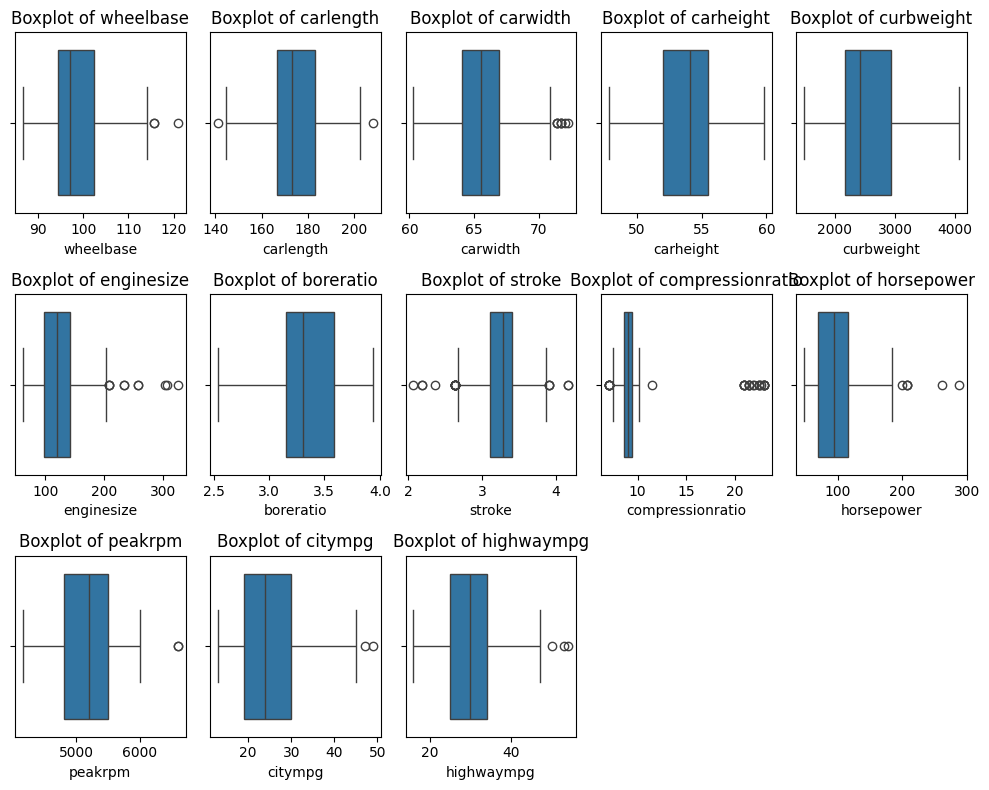

In [15]:
# Visualize numerical features
plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 5, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [16]:
# Function to detect and cap outliers using IQR
def cap_outliers_iqr(df):
    outliers_dict = {}  # Dictionary to store the number of outliers for each column
    
   
    for column in numeric_columns:  # Only consider numeric columns
        # Calculate the Q1, Q3, and IQR for the column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify the outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = len(outliers)
        
        # Capping the outliers with the mean value of the column
        mean_value = df[column].mean()
        df[column] = df[column].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)
    
    return df, outliers_dict

# Apply outlier capping
df, outliers_dict = cap_outliers_iqr(df)

# Output the number of outliers per column
print("Outliers in each column:")
for column, outlier_count in outliers_dict.items():
    print(f"{column}: {outlier_count} outliers")

Outliers in each column:
wheelbase: 3 outliers
carlength: 2 outliers
carwidth: 8 outliers
carheight: 0 outliers
curbweight: 0 outliers
enginesize: 10 outliers
boreratio: 0 outliers
stroke: 20 outliers
compressionratio: 28 outliers
horsepower: 6 outliers
peakrpm: 2 outliers
citympg: 2 outliers
highwaympg: 3 outliers


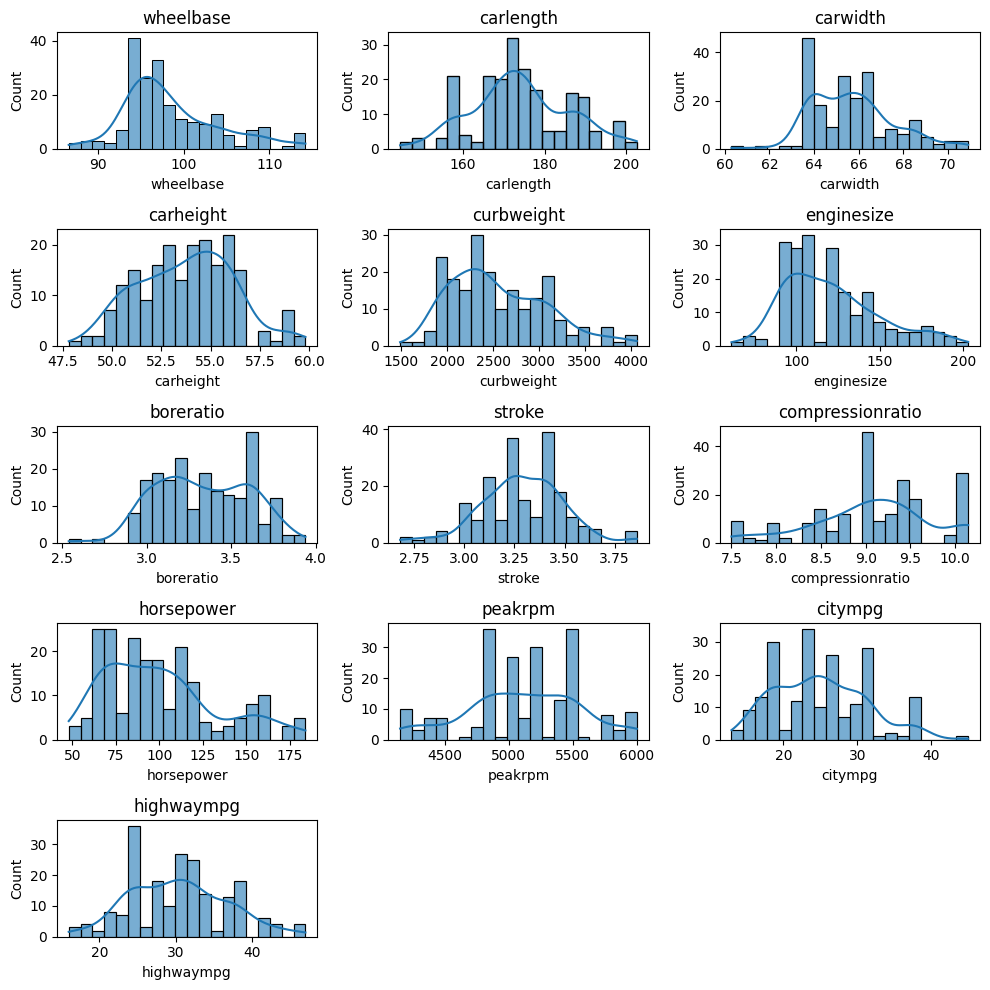

In [17]:
#Distribution plots for all numeric features
plt.figure(figsize=(10, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=df, x=column, kde=True, bins=20, alpha=0.6, legend=False)  # Set legend=False
    plt.title(column)
    plt.tight_layout()    
plt.show()

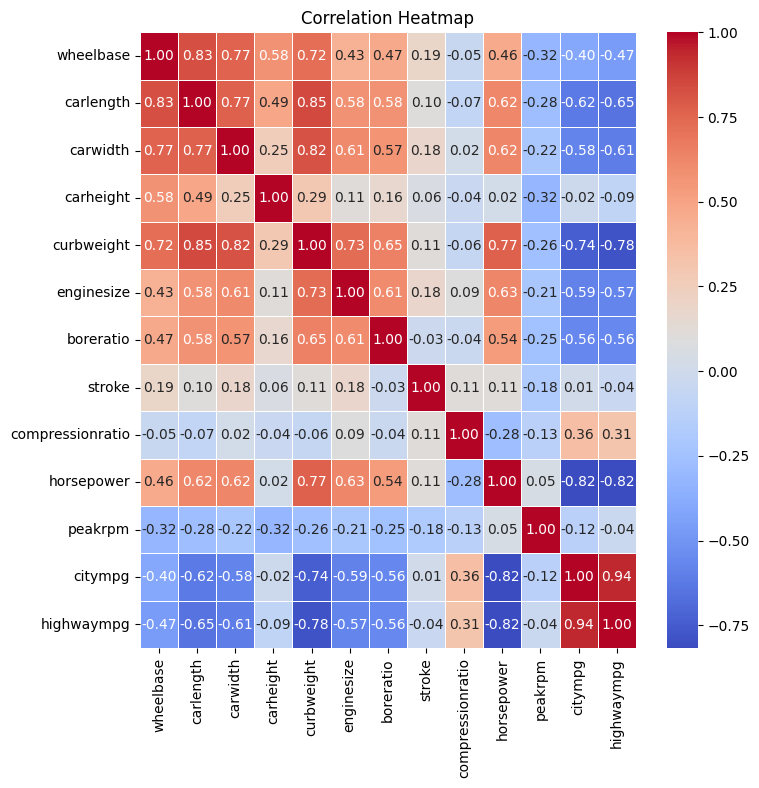

In [18]:
# Calculate correlations
corr_matrix = df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


Feature Engineering

In this section, we convert categorical variables into numerical formats to make them suitable for machine learning models.

Label Encoding:
The doornumber and enginelocation columns, which contain categorical textual values, are encoded into numerical values using Label Encoding. Each unique category in these columns is assigned a numerical label.

Manual Encoding for cylindernumber:
The cylindernumber column contains textual values such as 'four', 'six', etc. These are manually replaced with their corresponding numerical values, representing the number of cylinders in the engine.

One-Hot Encoding:
For other categorical variables such as fueltype, aspiration, carbody, drivewheel, enginetype, and fuelsystem, One-Hot Encoding is applied. This technique creates binary columns for each category, representing the presence of each category with 0 or 1. The drop_first=False parameter ensures that all categories are kept without dropping one as a reference.

In [19]:

#Label Encoding for specific columns
labelencoder=LabelEncoder()
df['doornumber']=labelencoder.fit_transform(df['doornumber'])
df['enginelocation']=labelencoder.fit_transform(df['enginelocation'])

In [20]:
# Replace textual values with corresponding numbers directly

df['cylindernumber'] = df['cylindernumber'].replace(
    ['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'], 
    [4, 6, 5, 3, 12, 2, 8]
)

# Check the updated column
print(df['cylindernumber'].unique())

[ 4  6  5  3 12  2  8]


C:\Users\jeeva\AppData\Local\Temp\ipykernel_19600\3790729931.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cylindernumber'] = df['cylindernumber'].replace(


In [21]:
#One hot Encoding for remaining categorical variable
df=pd.get_dummies(df, columns=['fueltype', 'aspiration', 'carbody', 
                                  'drivewheel', 'enginetype', 'fuelsystem'], drop_first=False)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 0 to 204
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   symboling            204 non-null    int64  
 1   doornumber           204 non-null    int32  
 2   enginelocation       204 non-null    int32  
 3   wheelbase            204 non-null    float64
 4   carlength            204 non-null    float64
 5   carwidth             204 non-null    float64
 6   carheight            204 non-null    float64
 7   curbweight           204 non-null    int64  
 8   cylindernumber       204 non-null    int64  
 9   enginesize           204 non-null    float64
 10  boreratio            204 non-null    float64
 11  stroke               204 non-null    float64
 12  compressionratio     204 non-null    float64
 13  horsepower           204 non-null    float64
 14  peakrpm              204 non-null    float64
 15  citympg              204 non-null    float64


Feature Selection

In this step, we use a Random Forest Regressor to identify the most important features affecting car prices.

Random Forest Model:
A Random Forest Regressor is trained on the dataset, using all features except the target variables (price and log_price). The model is fitted to predict the log-transformed price (log_price), which allows us to understand how the features contribute to price prediction.

Feature Importance:
The feature importance is extracted from the trained Random Forest model. Each feature's importance score reflects its contribution to the model's predictions. A higher importance score indicates that the feature plays a more significant role in predicting car prices.

Feature Selection:
The top 15 most important features are selected based on their importance scores. These features are then used for further analysis and model refinement.

Visualization:
A horizontal bar plot is generated to visually represent the importance of each feature. The features with the highest importance are displayed at the top, helping to identify which variables have the greatest impact on predicting car prices.

This process helps in understanding which factors are the most influential when predicting car prices, aiding in feature selection and model optimization.


Feature Importance:
                feature    importance
7            curbweight  6.019571e-01
16           highwaympg  1.799379e-01
15              citympg  4.415689e-02
13           horsepower  3.442873e-02
9            enginesize  2.246906e-02
8        cylindernumber  1.825668e-02
10            boreratio  1.489429e-02
3             wheelbase  1.187984e-02
14              peakrpm  1.040877e-02
5              carwidth  9.579611e-03
4             carlength  8.829796e-03
11               stroke  8.652237e-03
6             carheight  5.182676e-03
12     compressionratio  4.556064e-03
23    carbody_hatchback  3.253093e-03
2        enginelocation  2.563350e-03
20     aspiration_turbo  2.154834e-03
0             symboling  2.043217e-03
41      fuelsystem_mpfi  1.551183e-03
19       aspiration_std  1.387311e-03
37      fuelsystem_2bbl  1.370871e-03
1            doornumber  1.353429e-03
24        carbody_sedan  1.302917e-03
33      enginetype_ohcf  1.076382e-03
21  carbody_convertible  9.56

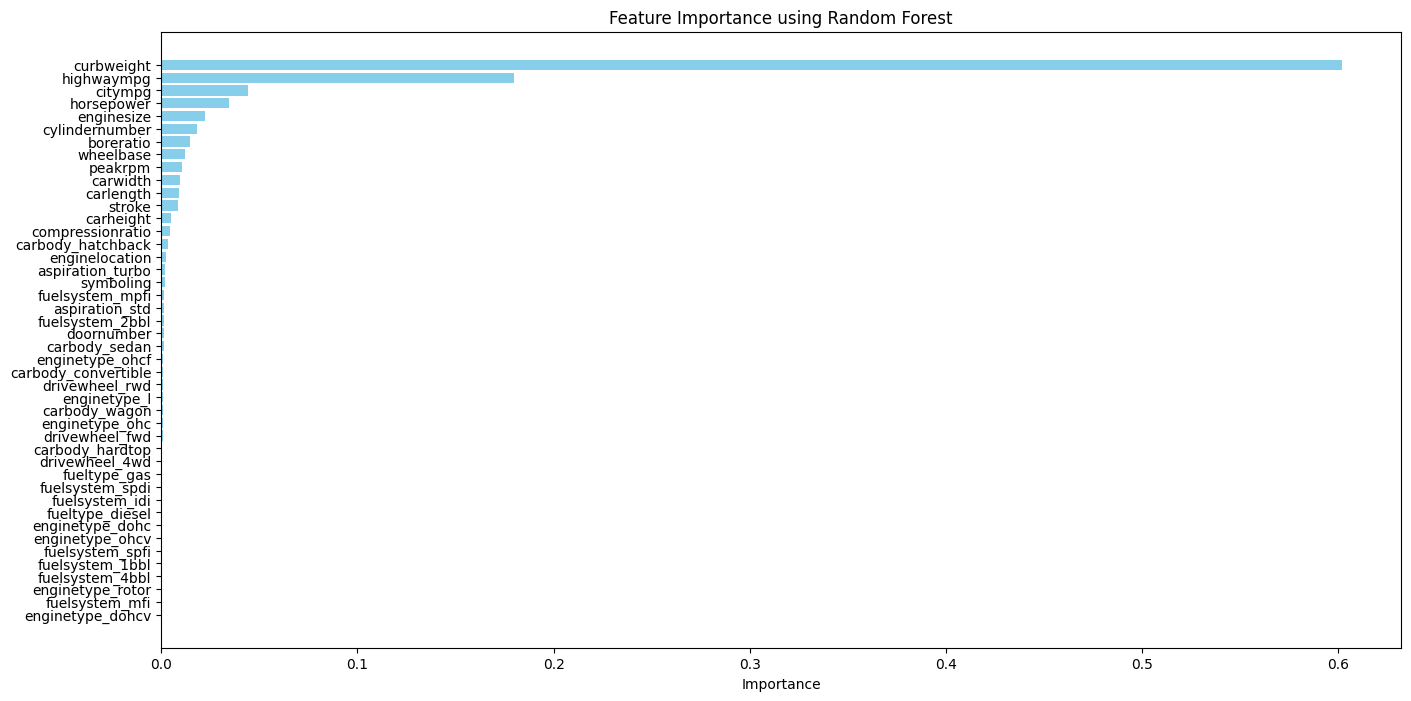

In [23]:
# Fit the Random Forest model
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(df.drop(['price','log_price'], axis=1), df['log_price'])

# Get the feature importances
feature_importance = pd.DataFrame({
    'feature': df.drop(['price','log_price'], axis=1).columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Print the feature importances
print("\nFeature Importance:")
print(feature_importance)

# Optionally, plot the feature importance
plt.figure(figsize=(16, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()

In [25]:
# Step 1: Select the top 15 features
top_15_features = feature_importance['feature'].head(15).values

# Step 2: Prepare the data with top 15 features
X= df[top_15_features]
X1=df.drop(['price','log_price'], axis=1)
y = df['log_price']  # Target variable

Data Splitting
In this step, the dataset is split into training and testing sets to evaluate the model's performance.

Training and Testing Split:
The data is divided into two subsets: one for training the model and one for testing it. We use the train_test_split function from scikit-learn, where:
X1: Features (excluding the target variable price and log_price).
y: Target variable (log_price).
Test size: 20% of the data is reserved for testing, while the remaining 80% is used for training the model.
Random state: A random seed (random_state=42) ensures reproducibility of the data split.
This split ensures that the model is trained on one portion of the data and evaluated on another, preventing overfitting and giving a more accurate estimate of its performance on unseen data.

In [38]:
#Split the data into training and testing sets
print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Splitting data...


Feature Scaling
Feature scaling is applied to standardize the numerical features so that they have a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms.

StandardScaler:
The StandardScaler from scikit-learn is used to scale the features. The scaler computes the mean and standard deviation of the training data, and then transforms both the training and testing data based on these statistics.
fit_transform is applied to the training data (X_train) to calculate the scaling parameters and apply the transformation.
transform is then applied to the test data (X_test) using the same scaling parameters derived from the training set, ensuring that both sets are scaled consistently.
Scaling helps to ensure that features with different units or scales (e.g., engine size, curb weight) are treated equally by the model, improving the performance of algorithms that are sensitive to feature magnitudes, such as Support Vector Regressor and Gradient Boosting Regressor.

In [39]:
# Feature Scaling
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


Model Training and Evaluation
In this step, we train and evaluate multiple regression models to predict car prices, and compare their performance based on several evaluation metrics.

Model Training:
We define a dictionary models containing five different regression models:

Linear Regression
Support Vector Regressor (SVR)
Random Forest Regressor
Gradient Boosting Regressor
Decision Tree Regressor
Each model is trained using the scaled training data (X_train_scaled and y_train).

Model Evaluation:
After training each model, we predict the target variable (y_pred) using the scaled test data (X_test_scaled). Then, we evaluate the performance of each model based on the following metrics:

Mean Absolute Error (MAE): Measures the average magnitude of errors in predictions.
Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values.
Root Mean Squared Error (RMSE): Provides the square root of the MSE, making it interpretable in the same unit as the target variable.
R-Squared (R2): Measures the proportion of variance in the target variable that is explained by the model.
Best Model Selection:
The model with the highest R-squared value is selected as the best model. The evaluation results for all models are printed for comparison.

By examining these metrics, we can assess which model provides the best fit for predicting car prices based on the input features.

In [40]:
# 11. Build and evaluate models
print("\nTraining models...")
models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}


Training models...


In [41]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # 12. Model Evaluation
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }


Training Linear Regression...

Training SVR...

Training Random Forest...

Training Gradient Boosting...

Training DecisionTree...


In [42]:
# Print model performance
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Model Performance:

Linear Regression:
MAE: 0.1698
MSE: 0.0508
RMSE: 0.2255
R2: 0.8330

SVR:
MAE: 0.1937
MSE: 0.0548
RMSE: 0.2342
R2: 0.8199

Random Forest:
MAE: 0.1390
MSE: 0.0398
RMSE: 0.1996
R2: 0.8692

Gradient Boosting:
MAE: 0.1425
MSE: 0.0366
RMSE: 0.1912
R2: 0.8799

DecisionTree:
MAE: 0.1809
MSE: 0.0682
RMSE: 0.2612
R2: 0.7759


In [43]:
# Find best model
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: Gradient Boosting


Hyperparameter Tuning:
In this step, we perform hyperparameter tuning to improve the performance of the best model, selected from the previous step.

Model Selection for Tuning:
Based on the previous evaluation, the best model is selected for hyperparameter tuning. If the best model is a Random Forest Regressor, we define a set of hyperparameters to search:

n_estimators: Number of trees in the forest.
max_depth: Maximum depth of the trees.
min_samples_split: Minimum number of samples required to split an internal node.
For the Gradient Boosting Regressor, we tune:

n_estimators: Number of boosting stages (trees).
learning_rate: Controls the contribution of each tree to the final model.
max_depth: Maximum depth of the individual trees.
GridSearchCV:
We use GridSearchCV from scikit-learn to perform an exhaustive search over the specified parameter grid. This method evaluates all possible combinations of hyperparameters using cross-validation (with cv=5), and the performance is measured using neg_mean_squared_error as the scoring metric.

Best Parameters:
Once the grid search is completed, the best parameters are selected, and the model is retrained using these optimal values.

This process helps in selecting the best combination of hyperparameters that can potentially improve the model's performance by reducing overfitting and increasing accuracy.

In [44]:
# 13. Hyperparameter Tuning
print("\nTuning best model...")
if isinstance(best_model, RandomForestRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
elif isinstance(best_model, GradientBoostingRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
else:
    param_grid = {}


Tuning best model...


In [45]:
if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Model Saving
In this step, we save the trained model and the scaler to disk for future use. This allows us to make predictions on new data without needing to retrain the model each time.

Saving the Best Model:
We use joblib.dump() to save the best model (the one with the optimal hyperparameters after tuning) to a file. The model is saved as 'CarPrice.joblib'.

Saving the Scaler:
Since we used StandardScaler for feature scaling, we also save the scaler object using joblib.dump(). This ensures that we can apply the same scaling to new data when making predictions in the future.

Confirmation:
After the saving process is complete, a message is printed to confirm that both the model and the scaler have been saved successfully.

By saving the model and scaler, we can easily load and use them for making predictions on unseen data, ensuring consistent results without needing to retrain the model every time.

In [46]:
# 14. Save the Model
print("\nSaving model...")
joblib.dump(best_model, 'CarPrice.joblib')
joblib.dump(scaler, 'CarPrice.joblib')
print("Model and scaler saved as 'CarPrice.joblib' and 'CarPrice.joblib'")


Saving model...
Model and scaler saved as 'CarPrice.joblib' and 'CarPrice.joblib'


Testing with Unseen Data
In this step, we evaluate the performance of the final model on unseen data (the test set). The test set was not used during model training, so it serves as a good representation of how the model will perform on new, unseen data.

Final Predictions:
Using the best model (after hyperparameter tuning and training), we predict the target variable log_price on the test set (X_test_scaled).

Evaluation Metrics:
After generating the predictions, we evaluate the model's performance using common regression metrics:

MAE (Mean Absolute Error): Measures the average magnitude of the errors in a set of predictions, without considering their direction.
MSE (Mean Squared Error): Measures the average squared difference between the estimated values and the actual value.
RMSE (Root Mean Squared Error): The square root of the MSE, giving us an error metric in the same unit as the target variable.
R² (R-squared): Indicates how well the independent variables explain the variance in the target variable. A higher R² indicates a better fit.
Final Performance:
The calculated metrics are printed to assess the final performance of the model on the unseen data. This helps in understanding how well the model generalizes beyond the training data.

By testing with unseen data, we can confirm whether the model has overfitted to the training data or if it performs well on new data, thus providing a reliable measure of its real-world performance.

In [47]:
# 15. Test with Unseen Data
print("\nTesting with unseen data...")
final_predictions = best_model.predict(X_test_scaled)
final_metrics = {
    'MAE': mean_absolute_error(y_test, final_predictions),
    'MSE': mean_squared_error(y_test, final_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_test, final_predictions)),
    'R2': r2_score(y_test, final_predictions)
}


Testing with unseen data...


In [48]:
print("\nFinal Model Performance:")
for metric_name, value in final_metrics.items():
    print(f"{metric_name}: {value:.4f}")


Final Model Performance:
MAE: 0.1425
MSE: 0.0366
RMSE: 0.1912
R2: 0.8799
